In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_tree, plot_importance
from sklearn.neighbors import KNeighborsRegressor

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.inspection import permutation_importance
import shap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [ ]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [ ]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 1. 데이터 불러오기 및 분석

In [ ]:
# 데이터 불러오기
df17 = pd.read_csv('/content/sample_data/data2017.csv', sep=',', index_col=0)
df18 = pd.read_csv('/content/sample_data/data2018.csv', sep=',', index_col=0)
df19 = pd.read_csv('/content/sample_data/data2019.csv', sep=',', index_col=0)
df20 = pd.read_csv('/content/sample_data/data2020.csv', sep=',', index_col=0)
df21 = pd.read_csv('/content/sample_data/data2021.csv', sep=',', index_col=0)

df_total = pd.concat([df17, df18, df19, df20, df21]) # 2017~2021 병합
df_test = pd.read_csv('data2022.csv', sep=',', index_col=0) # 2022

FileNotFoundError: ignored

In [ ]:
display(df_total.head())
display(df_test.head())

,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,남자40세부터44세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
기준일ID,,,,,,,,,,,,,,,,,,,,,
20170101,0,31535.2200,1945.4402,566.4588,631.5581,991.9184,1297.1287,1223.1529,1552.9448,1236.7535,...,1157.6661,1107.6781,1282.9235,1029.4360,998.0414,874.5643,1162.1547,1053.0477,964.3940,2025.4819
20170101,1,31188.9174,1930.4766,562.1018,625.2151,1030.6281,1307.7381,1183.0956,1491.5827,1236.8635,...,1120.0051,1102.5198,1271.8997,1027.2574,1038.7528,857.9100,1149.7532,1042.7411,919.0115,2062.2422
20170101,2,31240.4974,1921.1864,559.3965,658.7463,1058.7082,1311.9591,1186.2600,1537.3732,1211.8326,...,1103.1547,1112.4579,1282.9366,1027.8901,1020.0177,853.3890,1193.4472,1011.2073,889.9325,1960.1236
20170101,3,31442.4314,1946.4476,566.7525,649.0804,1057.9119,1324.2638,1202.1250,1521.2732,1232.8897,...,1116.2165,1102.0668,1260.8472,1007.6650,1042.9554,896.0038,1163.0355,1056.6428,891.9177,2060.1872
20170101,4,31922.7751,1953.7713,568.8845,623.2087,1063.2557,1342.9146,1209.2680,1556.0675,1282.1621,...,1187.5457,1120.2232,1281.2738,1064.0655,1045.2130,895.8336,1191.7017,1045.3362,874.4984,2038.6212


,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,남자40세부터44세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
기준일ID,,,,,,,,,,,,,,,,,,,,,
20220101,0,30509.7386,1884.2082,548.6298,635.1617,816.1686,1140.0136,1310.3109,1528.2100,1490.5116,...,1034.3335,1210.2650,1427.1433,1218.2473,1167.4485,823.9020,1032.1651,872.8850,767.0226,1737.1551
20220101,1,30759.5067,1918.5330,558.6242,665.6793,822.6910,1159.5614,1293.1350,1542.7586,1485.2323,...,1072.8086,1193.7476,1403.5719,1248.7765,1180.9186,838.5323,998.1091,862.3041,776.7908,1753.0597
20220101,2,31048.8787,2068.1943,602.2013,680.8294,819.7141,1164.5819,1331.9311,1537.8207,1493.3085,...,1090.9845,1208.3281,1410.2452,1268.6557,1197.7707,840.6799,1026.5402,882.2846,772.8478,1757.8801
20220101,3,31076.1092,1951.7702,568.3016,690.9847,804.2219,1180.7028,1336.8848,1542.4681,1474.2258,...,1104.3879,1224.9349,1414.4162,1275.0993,1207.1428,856.1711,1042.1205,891.6092,785.1560,1747.8953
20220101,4,31714.9309,2058.5797,599.4019,708.3313,847.9704,1168.0681,1355.7735,1586.0121,1506.2284,...,1152.1235,1269.6214,1442.1163,1296.6590,1206.5972,875.1503,1052.5656,877.6836,795.0789,1760.4713


In [ ]:
# ['기준일ID']에 to_datetime 함수를 사용하여 데이터 형태 변경
df_total.index = pd.to_datetime(df_total.index, format='%Y%m%d')
df_test.index = pd.to_datetime(df_test.index, format='%Y%m%d')

In [ ]:
display(df_total.head())
display(df_test.head())

,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,남자40세부터44세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
기준일ID,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,31535.2200,1945.4402,566.4588,631.5581,991.9184,1297.1287,1223.1529,1552.9448,1236.7535,...,1157.6661,1107.6781,1282.9235,1029.4360,998.0414,874.5643,1162.1547,1053.0477,964.3940,2025.4819
2017-01-01,1,31188.9174,1930.4766,562.1018,625.2151,1030.6281,1307.7381,1183.0956,1491.5827,1236.8635,...,1120.0051,1102.5198,1271.8997,1027.2574,1038.7528,857.9100,1149.7532,1042.7411,919.0115,2062.2422
2017-01-01,2,31240.4974,1921.1864,559.3965,658.7463,1058.7082,1311.9591,1186.2600,1537.3732,1211.8326,...,1103.1547,1112.4579,1282.9366,1027.8901,1020.0177,853.3890,1193.4472,1011.2073,889.9325,1960.1236
2017-01-01,3,31442.4314,1946.4476,566.7525,649.0804,1057.9119,1324.2638,1202.1250,1521.2732,1232.8897,...,1116.2165,1102.0668,1260.8472,1007.6650,1042.9554,896.0038,1163.0355,1056.6428,891.9177,2060.1872
2017-01-01,4,31922.7751,1953.7713,568.8845,623.2087,1063.2557,1342.9146,1209.2680,1556.0675,1282.1621,...,1187.5457,1120.2232,1281.2738,1064.0655,1045.2130,895.8336,1191.7017,1045.3362,874.4984,2038.6212


,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,남자40세부터44세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
기준일ID,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0,30509.7386,1884.2082,548.6298,635.1617,816.1686,1140.0136,1310.3109,1528.2100,1490.5116,...,1034.3335,1210.2650,1427.1433,1218.2473,1167.4485,823.9020,1032.1651,872.8850,767.0226,1737.1551
2022-01-01,1,30759.5067,1918.5330,558.6242,665.6793,822.6910,1159.5614,1293.1350,1542.7586,1485.2323,...,1072.8086,1193.7476,1403.5719,1248.7765,1180.9186,838.5323,998.1091,862.3041,776.7908,1753.0597
2022-01-01,2,31048.8787,2068.1943,602.2013,680.8294,819.7141,1164.5819,1331.9311,1537.8207,1493.3085,...,1090.9845,1208.3281,1410.2452,1268.6557,1197.7707,840.6799,1026.5402,882.2846,772.8478,1757.8801
2022-01-01,3,31076.1092,1951.7702,568.3016,690.9847,804.2219,1180.7028,1336.8848,1542.4681,1474.2258,...,1104.3879,1224.9349,1414.4162,1275.0993,1207.1428,856.1711,1042.1205,891.6092,785.1560,1747.8953
2022-01-01,4,31714.9309,2058.5797,599.4019,708.3313,847.9704,1168.0681,1355.7735,1586.0121,1506.2284,...,1152.1235,1269.6214,1442.1163,1296.6590,1206.5972,875.1503,1052.5656,877.6836,795.0789,1760.4713


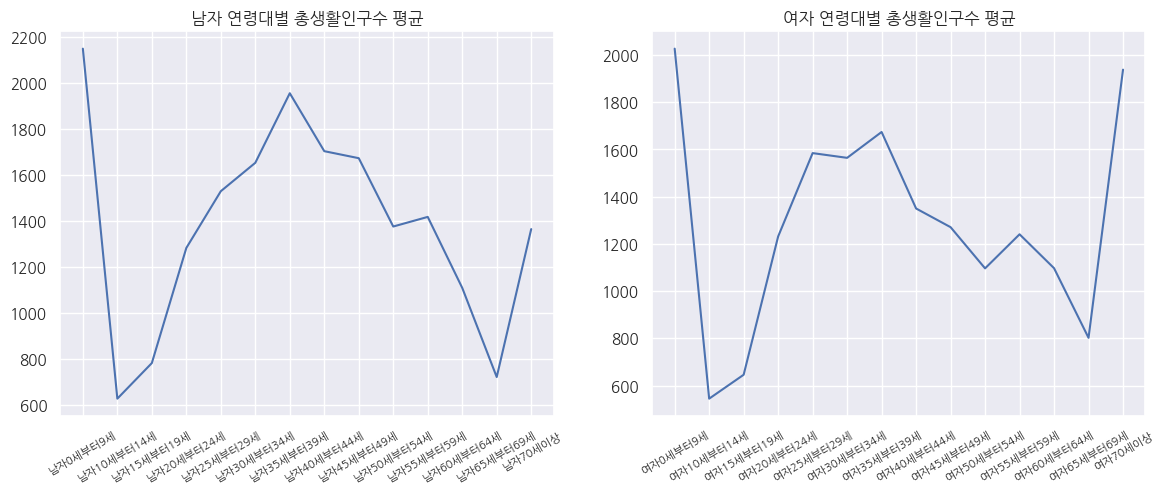

In [ ]:
gender_age_mean = df_total.mean()[2:].to_frame()
gender_age_mean.index = gender_age_mean.index.str[:-5]
# gender_age_mean

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(gender_age_mean[:14])
plt.title('남자 연령대별 총생활인구수 평균')
plt.xticks(rotation=30, fontsize=8)

plt.subplot(1,2,2)
plt.plot(gender_age_mean[14:])
plt.title('여자 연령대별 총생활인구수 평균')
plt.xticks(rotation=30, fontsize=8)

plt.show()

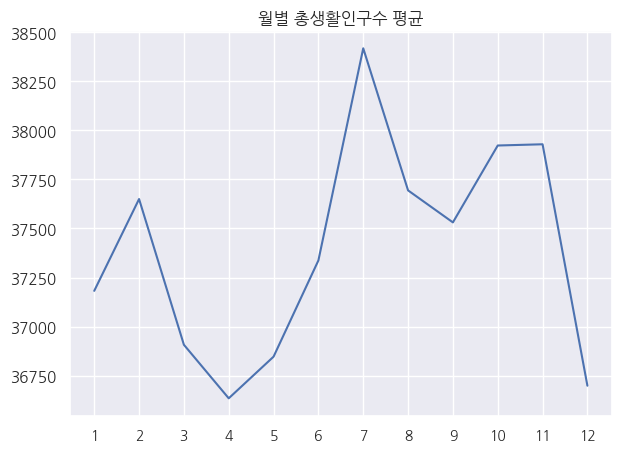

In [ ]:
month_mean = df_total.groupby(df_total.index.month)['총생활인구수'].mean().to_frame()
# month_mean

plt.figure(figsize=(7, 5))
plt.plot(month_mean)
plt.title('월별 총생활인구수 평균')
plt.xticks(month_mean.index, fontsize=10)
plt.show()

In [ ]:
month_mean['season'] = 'winter'
month_mean.loc[3, 'season'] = 'spring'
month_mean.loc[4, 'season'] = 'spring'
month_mean.loc[5, 'season'] = 'spring'
month_mean.loc[6, 'season'] = 'summer'
month_mean.loc[7, 'season'] = 'summer'
month_mean.loc[8, 'season'] = 'summer'
month_mean.loc[9, 'season'] = 'autumn'
month_mean.loc[10, 'season'] = 'autumn'
month_mean.loc[11, 'season'] = 'autumn'
month_mean

,총생활인구수,season
기준일ID,,
1,37182.156920,winter
2,37649.973501,winter
3,36907.433162,spring
4,36634.640213,spring
5,36846.820456,spring
6,37337.194923,summer
7,38418.031533,summer
8,37694.035562,summer
9,37530.955448,autumn


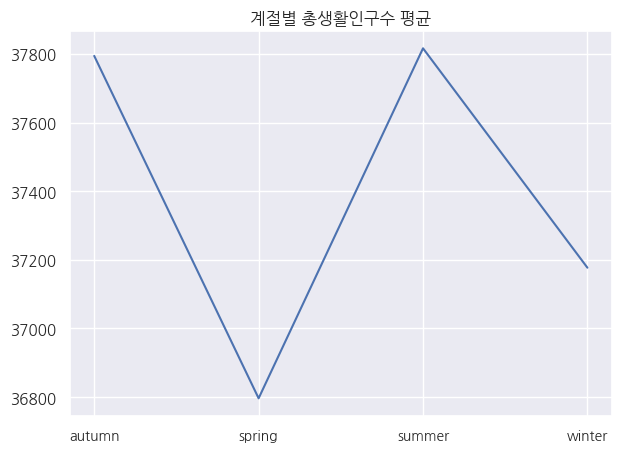

In [ ]:
season_mean = month_mean.groupby('season').mean()
# season_mean

plt.figure(figsize=(7, 5))
plt.plot(season_mean)
plt.title('계절별 총생활인구수 평균')
plt.xticks(fontsize=10)
plt.show()

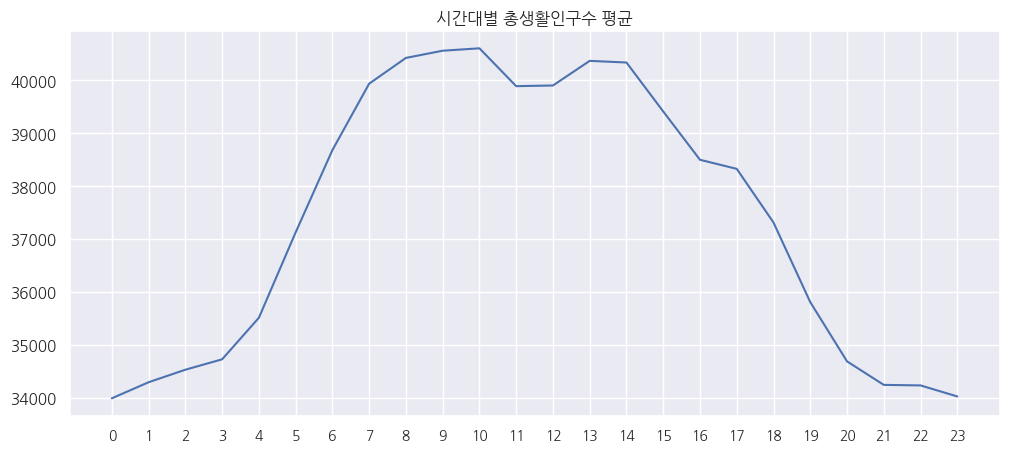

In [ ]:
hour_mean = df_total.groupby(df_total['시간대구분'])['총생활인구수'].mean().to_frame()
# hour_mean

plt.figure(figsize=(12, 5))
plt.plot(hour_mean)
plt.title('시간대별 총생활인구수 평균')
plt.xticks(hour_mean.index, fontsize=10)
plt.show()

In [ ]:
# 1. 총생활인구수가 가장 높은 연령대: 남여0세부터9세(영유아, 압도적으로 높음), 남여35세부터29세(직장인), 여자70세이상
# 2. 총생활인구수가 가장 낮은 연령대: 남여10세부터14세
# 3. 총생활인구수가 가장 높은 달: 7월
# 4. 총생활인구수가 가장 낮은 달: 4월, 12월
# 5. 총생활인구수가 가장 높은 계절: 여름, 가을
# 6. 총생활인구수가 가장 낮은 계절: 봄, 겨울
# 7. 총생활인구수가 가장 높은 시간: 8, 9, 10 (출퇴근 시간)
# 8. 총생활인구수가 가장 낮은 시간: 0, 23 (자정, 출퇴근 시간 비교했을 때 5,000 이상 차이가 남 -> 회사 밀집 지역?)

In [ ]:
# CSV로 저장
df_total.to_csv('df_total.csv')
df_test.to_csv('df_test.csv')

# 2. 데이터 전처리

In [ ]:
# 17년도부터 21년도 까지의 데이터를 train_set
df_total = pd.read_csv('df_total.csv')
# 22년도의 6개월치 데이터를 test_set
df_test = pd.read_csv('df_test.csv')

In [ ]:
# pd.to_datetime() 함수를 사용해 '기준일ID'열을 datetime 형식으로 변경
df_total['기준일ID'] = pd.to_datetime(df_total['기준일ID'])
df_test['기준일ID'] = pd.to_datetime(df_test['기준일ID'])

In [ ]:
# year, month, day 열로 기존 데이터 프레임에 연월일 정보를 저장
df_total['year'] = df_total['기준일ID'].dt.year
df_total['month'] = df_total['기준일ID'].dt.month
df_total['day'] = df_total['기준일ID'].dt.day

df_test['year'] = df_test['기준일ID'].dt.year
df_test['month'] = df_test['기준일ID'].dt.month
df_test['day'] = df_test['기준일ID'].dt.day

In [ ]:
display(df_total.head())
display(df_test.head())

,기준일ID,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,...,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수,year,month,day
0,2017-01-01,0,31535.2200,1945.4402,566.4588,631.5581,991.9184,1297.1287,1223.1529,1552.9448,...,1029.4360,998.0414,874.5643,1162.1547,1053.0477,964.3940,2025.4819,2017,1,1
1,2017-01-01,1,31188.9174,1930.4766,562.1018,625.2151,1030.6281,1307.7381,1183.0956,1491.5827,...,1027.2574,1038.7528,857.9100,1149.7532,1042.7411,919.0115,2062.2422,2017,1,1
2,2017-01-01,2,31240.4974,1921.1864,559.3965,658.7463,1058.7082,1311.9591,1186.2600,1537.3732,...,1027.8901,1020.0177,853.3890,1193.4472,1011.2073,889.9325,1960.1236,2017,1,1
3,2017-01-01,3,31442.4314,1946.4476,566.7525,649.0804,1057.9119,1324.2638,1202.1250,1521.2732,...,1007.6650,1042.9554,896.0038,1163.0355,1056.6428,891.9177,2060.1872,2017,1,1
4,2017-01-01,4,31922.7751,1953.7713,568.8845,623.2087,1063.2557,1342.9146,1209.2680,1556.0675,...,1064.0655,1045.2130,895.8336,1191.7017,1045.3362,874.4984,2038.6212,2017,1,1


,기준일ID,시간대구분,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,...,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수,year,month,day
0,2022-01-01,0,30509.7386,1884.2082,548.6298,635.1617,816.1686,1140.0136,1310.3109,1528.2100,...,1218.2473,1167.4485,823.9020,1032.1651,872.8850,767.0226,1737.1551,2022,1,1
1,2022-01-01,1,30759.5067,1918.5330,558.6242,665.6793,822.6910,1159.5614,1293.1350,1542.7586,...,1248.7765,1180.9186,838.5323,998.1091,862.3041,776.7908,1753.0597,2022,1,1
2,2022-01-01,2,31048.8787,2068.1943,602.2013,680.8294,819.7141,1164.5819,1331.9311,1537.8207,...,1268.6557,1197.7707,840.6799,1026.5402,882.2846,772.8478,1757.8801,2022,1,1
3,2022-01-01,3,31076.1092,1951.7702,568.3016,690.9847,804.2219,1180.7028,1336.8848,1542.4681,...,1275.0993,1207.1428,856.1711,1042.1205,891.6092,785.1560,1747.8953,2022,1,1
4,2022-01-01,4,31714.9309,2058.5797,599.4019,708.3313,847.9704,1168.0681,1355.7735,1586.0121,...,1296.6590,1206.5972,875.1503,1052.5656,877.6836,795.0789,1760.4713,2022,1,1


In [ ]:
# '시간대구분' column 을 'hour'로 rename
df_total = df_total.rename(columns={'시간대구분': 'hour'})
df_test = df_test.rename(columns={'시간대구분': 'hour'})

In [ ]:
# 시프트
# 24시간 전 생활인구, 7일 전 생활 인구를 기반으로 현재 생활인구를 예측
# 24시간 전 생활인구 데이터(train_x)
df_total['1d_ago'] = df_total['총생활인구수'].shift(24)
# 7일 전 생활인구 데이터(train_x)
df_total['7d_ago'] = df_total['총생활인구수'].shift(24*7)
# 24시간 전 생활인구 데이터(test_x)
df_test['1d_ago'] = df_test['총생활인구수'].shift(24)
# 7일 전 생활인구 데이터(test_x)
df_test['7d_ago'] = df_test['총생활인구수'].shift(24*7)

In [ ]:
# 1시간전 총생활인구수
df_total['1hr_ago'] = df_total['총생활인구수'].shift(1)
df_test['1hr_ago'] = df_test['총생활인구수'].shift(1)

In [ ]:
# rolling mean
df_total['총생활인구수_MA_1week'] = df_total['총생활인구수'].rolling(24).mean()
df_test['총생활인구수_MA_1week'] = df_test['총생활인구수'].rolling(24).mean()

In [ ]:
# 결측치 제거
df_total = df_total.dropna()
df_test = df_test.dropna()

In [ ]:
# 필요없는 변수 제거
df_total = df_total.drop(df_total.columns[3:31], axis=1)
df_test = df_test.drop(df_test.columns[3:31], axis=1)

In [ ]:
df_total = df_total.drop(df_total.columns[0], axis=1)
df_test = df_test.drop(df_test.columns[0], axis=1)

In [ ]:
display(df_total.head())
display(df_test.head())

,hour,총생활인구수,year,month,day,1d_ago,7d_ago,1hr_ago,총생활인구수_MA_1week
168,0,30716.3268,2017,1,8,31385.6529,31535.2200,31182.6156,35310.650092
169,1,30673.4813,2017,1,8,31403.0169,31188.9174,30716.3268,35280.252775
170,2,30535.9573,2017,1,8,31549.9889,31240.4974,30673.4813,35238.001458
171,3,30884.0372,2017,1,8,31738.8546,31442.4314,30535.9573,35202.384067
172,4,31353.9409,2017,1,8,32380.1733,31922.7751,30884.0372,35159.624383


,hour,총생활인구수,year,month,day,1d_ago,7d_ago,1hr_ago,총생활인구수_MA_1week
168,0,32163.4956,2022,1,8,32216.8776,30509.7386,32019.4949,35510.574971
169,1,32375.9407,2022,1,8,32646.5044,30759.5067,32163.4956,35499.301483
170,2,32817.7526,2022,1,8,33067.5077,31048.8787,32375.9407,35488.895021
171,3,33028.2197,2022,1,8,33134.7684,31076.1092,32817.7526,35484.455492
172,4,33827.9747,2022,1,8,33960.5255,31714.9309,33028.2197,35478.932542


In [ ]:
target = '총생활인구수'

In [ ]:
train_x = df_total.drop(target, axis=1)
train_y = df_total.loc[:, target]
test_x = df_test.drop(target, axis=1)
test_y = df_test.loc[:, target]

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((43344, 8), (43344,), (4176, 8), (4176,))

In [ ]:
# CSV로 저장
train_x.to_csv('train_x.csv', index = False)
train_y.to_csv('train_y.csv', index = False)
test_x.to_csv('test_x.csv', index = False)
test_y.to_csv('test_y.csv', index = False)

# 3. 모델링

In [ ]:
# 학습/평가 데이터 로딩
train_x = pd.read_csv('train_x.csv')
train_y = pd.read_csv('train_y.csv')
test_x = pd.read_csv('test_x.csv')
test_y = pd.read_csv('test_y.csv')

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((43344, 8), (43344, 1), (4176, 8), (4176, 1))

In [ ]:
display(train_x.head())
display(train_y.head())

,hour,year,month,day,1d_ago,7d_ago,1hr_ago,총생활인구수_MA_1week
0,0,2017,1,8,31385.6529,31535.2200,31182.6156,35310.650092
1,1,2017,1,8,31403.0169,31188.9174,30716.3268,35280.252775
2,2,2017,1,8,31549.9889,31240.4974,30673.4813,35238.001458
3,3,2017,1,8,31738.8546,31442.4314,30535.9573,35202.384067
4,4,2017,1,8,32380.1733,31922.7751,30884.0372,35159.624383


,총생활인구수
0,30716.3268
1,30673.4813
2,30535.9573
3,30884.0372
4,31353.9409


## 머신러닝
### 1. Linear Regression

In [ ]:
model_linear = LinearRegression()
model_linear.fit(train_x, train_y)

LinearRegression()

In [ ]:
y_pred = model_linear.predict(test_x)
print("RMSE :", mean_squared_error(test_y, y_pred, squared=False))
print("R2 :", r2_score(test_y, y_pred))

RMSE : 843.023134380587
R2 : 0.9442254494948367


In [ ]:
pfi_lr = permutation_importance(model_linear, test_x, test_y, n_repeats=10, scoring = 'r2', random_state=2023)

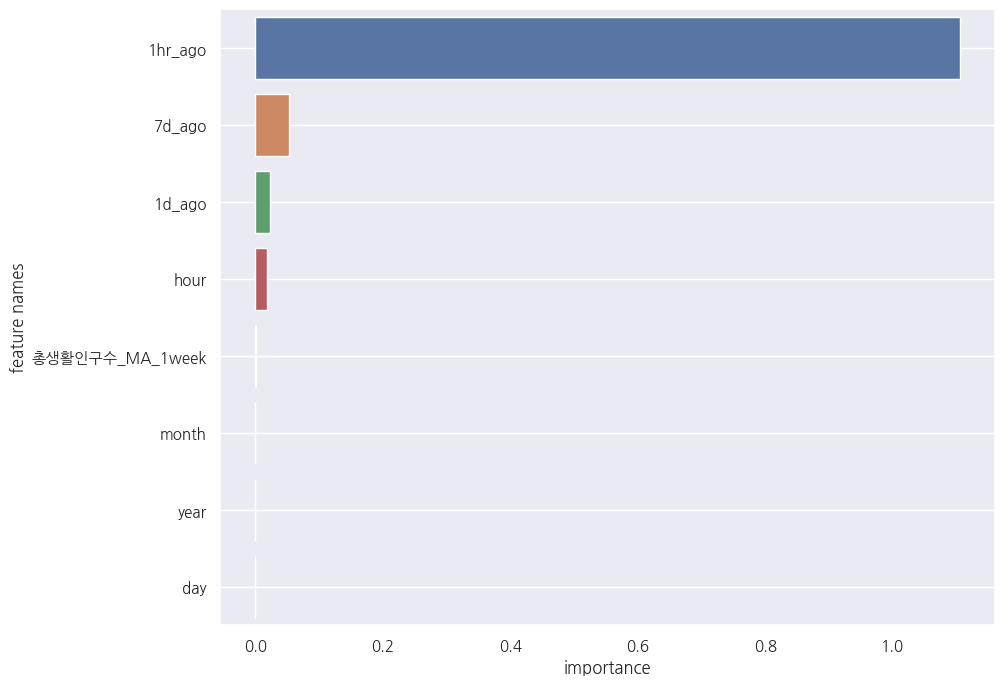

In [ ]:
result = plot_feature_importance(pfi_lr.importances_mean, list(train_x))

In [ ]:
result

,feature_names,feature_importance
0,1hr_ago,1.105511
1,7d_ago,0.052343
2,1d_ago,0.022240
3,hour,0.017905
4,총생활인구수_MA_1week,0.000497
5,month,0.000064
6,year,0.000000
7,day,-0.000062


### 2. 랜덤포레스트

In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(train_x, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [ ]:
pred_rf = model_rf.predict(test_x)
print("RMSE :", mean_squared_error(test_y, pred_rf, squared=False))
print("R2 :", r2_score(test_y, pred_rf))

RMSE : 616.0329129515396
R2 : 0.9702172411330376


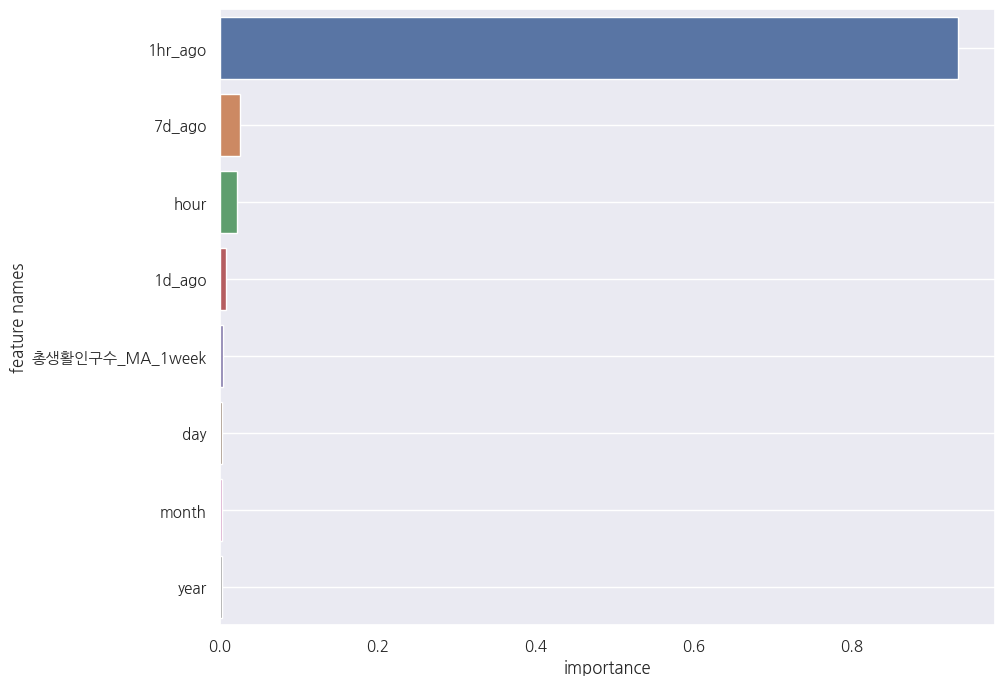

In [ ]:
result = plot_feature_importance(model_rf.feature_importances_, list(train_x))

In [ ]:
result

,feature_names,feature_importance
0,1hr_ago,0.935291
1,7d_ago,0.025124
2,hour,0.021851
3,1d_ago,0.007866
4,총생활인구수_MA_1week,0.003938
5,day,0.002242
6,month,0.001935
7,year,0.001754


### 3. XGB

In [ ]:
model_xgb = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model_xgb.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
pred_xgb = model_xgb.predict(test_x)
print("RMSE :", mean_squared_error(test_y, pred_xgb, squared=False))
print("R2 :", r2_score(test_y, pred_xgb))

RMSE : 1014.8763249493339
R2 : 0.9191679978321865


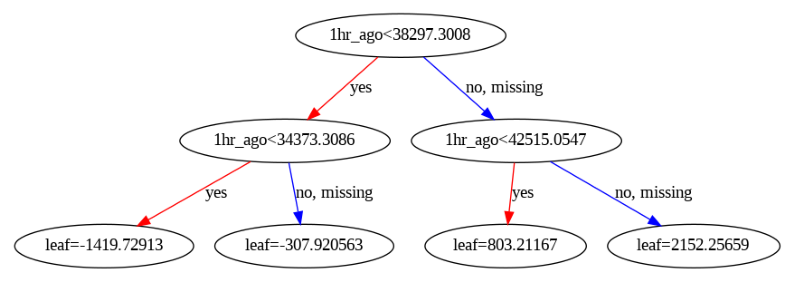

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10
plot_tree(model_xgb)
plt.show()

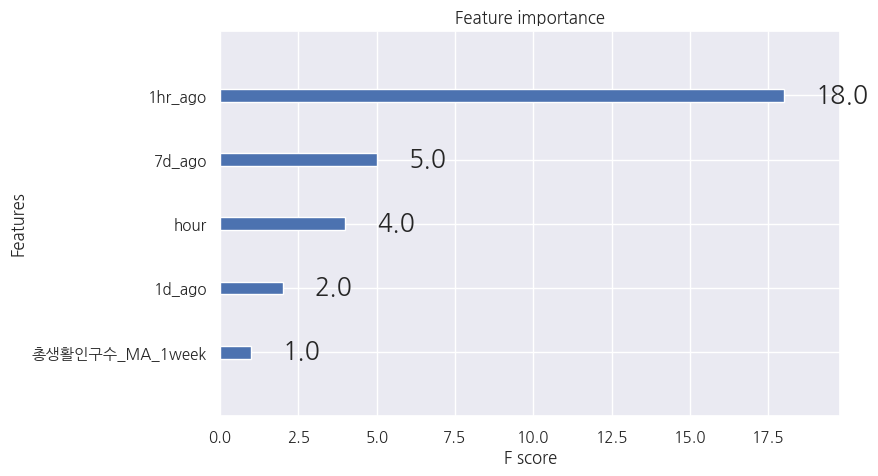

In [ ]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model_xgb)
plt.show()

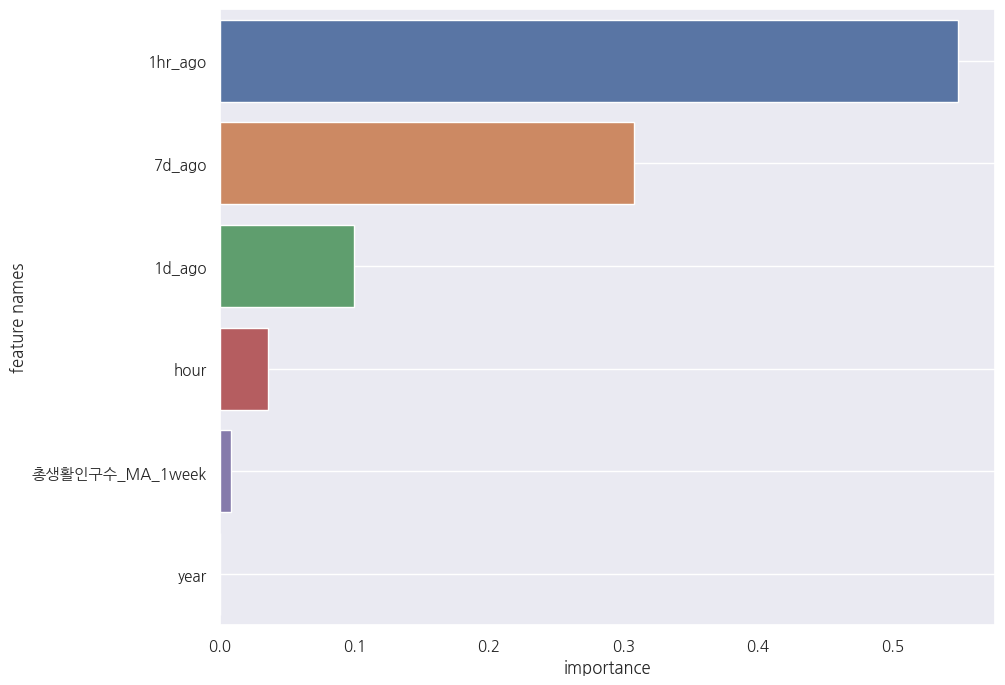

In [ ]:
result = plot_feature_importance(model_xgb.feature_importances_ , list(train_x),6)

In [ ]:
result

,feature_names,feature_importance
0,1hr_ago,0.549019
1,7d_ago,0.307861
2,1d_ago,0.099341
3,hour,0.035644
4,총생활인구수_MA_1week,0.008136
5,year,0.000000


### MinMax Scaling

In [ ]:
scaler = MinMaxScaler()
train_x_s = scaler.fit_transform(train_x)
test_x_s = scaler.transform(test_x)

### 4. KNN

In [ ]:
model_knn = KNeighborsRegressor()
model_knn.fit(train_x_s, train_y)

KNeighborsRegressor()

In [ ]:
pred_knn = model_knn.predict(test_x_s)
print("RMSE :", mean_squared_error(test_y, pred_knn, squared=False))
print("R2 :", r2_score(test_y, pred_knn))

RMSE : 1827.173155511112
R2 : 0.7379908214883943


In [ ]:
pfi_knn = permutation_importance(model_knn, test_x_s, test_y, n_repeats=10, scoring = 'r2', random_state=2023)

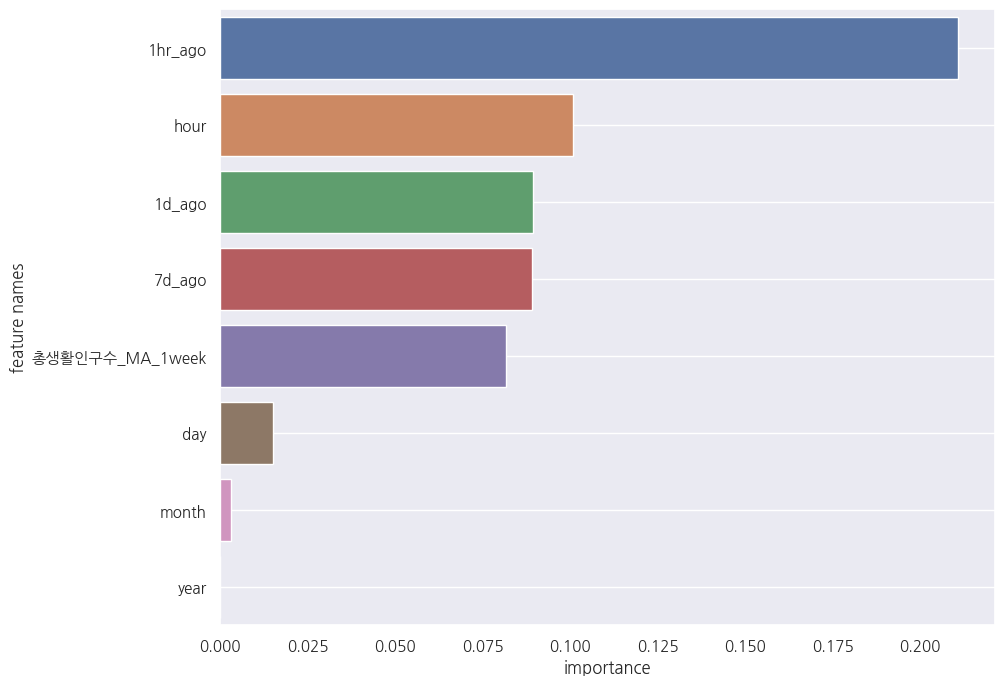

In [ ]:
result = plot_feature_importance(pfi_knn.importances_mean, list(train_x))

In [ ]:
result

,feature_names,feature_importance
0,1hr_ago,0.210848
1,hour,0.100848
2,1d_ago,0.089400
3,7d_ago,0.089039
4,총생활인구수_MA_1week,0.081718
5,day,0.015058
6,month,0.002966
7,year,0.000000


## 딥러닝

In [ ]:
nfeatures = train_x.shape[1]
clear_session()

model_dl = Sequential([Dense(64, input_shape = [nfeatures,], activation = 'relu'),
                       Dense(32, activation = 'relu'),
                       Dense(8, activation = 'relu'),
                       Dense(1)
                       ])

model_dl.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
history = model_dl.fit(train_x, train_y, epochs = 50, validation_split = .2).history

Epoch 1/50
1084/1084 [==============================] - 8s 6ms/step - loss: 55238928.0000 - val_loss: 569604.6875
Epoch 2/50
1084/1084 [==============================] - 3s 2ms/step - loss: 1143385.5000 - val_loss: 554876.5000
Epoch 3/50
1084/1084 [==============================] - 2s 2ms/step - loss: 984420.3125 - val_loss: 498836.9375
Epoch 4/50
1084/1084 [==============================] - 3s 2ms/step - loss: 938262.4375 - val_loss: 497609.6562
Epoch 5/50
1084/1084 [==============================] - 3s 3ms/step - loss: 937054.4375 - val_loss: 497755.4375
Epoch 6/50
1084/1084 [==============================] - 3s 3ms/step - loss: 935031.1875 - val_loss: 545300.0000
Epoch 7/50
1084/1084 [==============================] - 3s 3ms/step - loss: 926540.6875 - val_loss: 470355.2188
Epoch 8/50
1084/1084 [==============================] - 3s 3ms/step - loss: 915320.5625 - val_loss: 468366.5000
Epoch 9/50
1084/1084 [==============================] - 3s 3ms/step - loss: 906156.2500 - val_loss: 4

In [ ]:
pred_dl = model_dl.predict(test_x)
print("RMSE :", mean_squared_error(test_y, pred_dl, squared=False))
print("R2 :", r2_score(test_y, pred_dl))

131/131 [==============================] - 0s 2ms/step
RMSE : 723.3450135366415
R2 : 0.9589372456234166


In [ ]:
pfi_dl = permutation_importance(model_dl, test_x, test_y, n_repeats=10, scoring = 'r2', random_state=2023)

131/131 [==============================] - 0s 2ms/step


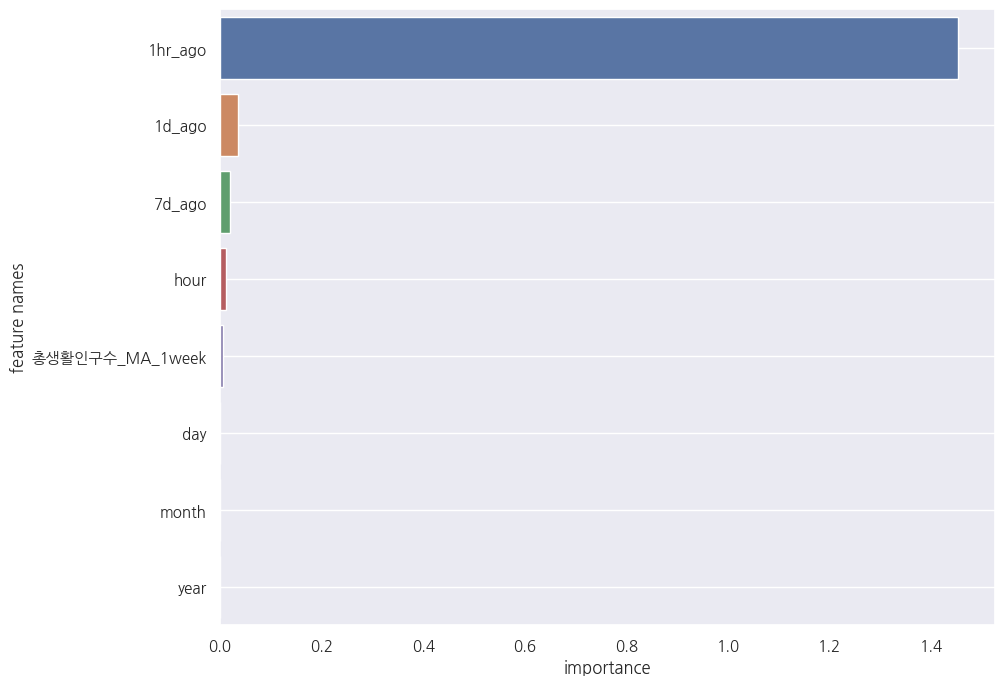

In [ ]:
result = plot_feature_importance(pfi_dl.importances_mean, list(train_x))

In [ ]:
result

,feature_names,feature_importance
0,1hr_ago,1.452891
1,1d_ago,0.035733
2,7d_ago,0.019584
3,hour,0.011079
4,총생활인구수_MA_1week,0.005711
5,day,0.000075
6,month,0.000012
7,year,0.000000
